In [1]:
#Import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import Dataset
main_data = pd.read_csv(r"C:\Users\Shree Ranganathan\Desktop\Portfolio Projects\Sales forecast Project\Amazon Product Sales & Forecast Analytics\Datasets\amazon_sales_forecast_data.csv")

In [3]:
#Load Dataset
main_data

,Order ID,Year,Quarter,Month,Day,Week,Week Number,Product,Category,Price,Quantity,Profit,Total Sales,Customer Name,Customer Location,Payment Method
0,ORD0123,2024,Qtr 3,August,23,Friday,5,Book,Books,15,3,13.5,45,Chris White,Boston,Gift Card
1,ORD0011,2024,Qtr 3,August,17,Saturday,6,Book,Books,15,2,9.0,30,David Lee,Boston,Amazon Pay
2,ORD0070,2025,Qtr 2,April,3,Thursday,4,Book,Books,15,1,4.5,15,Emily Johnson,Boston,Credit Card
3,ORD0396,2024,Qtr 3,July,10,Wednesday,3,Book,Books,15,3,13.5,45,Emma Clark,Boston,Credit Card
4,ORD0188,2024,Qtr 3,August,14,Wednesday,3,Book,Books,15,1,4.5,15,John Doe,Boston,Amazon Pay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD0088,2024,Qtr 4,December,2,Monday,1,Refrigerator,Home Appliances,1200,2,480.0,2400,Chris White,Seattle,Debit Card
496,ORD0425,2024,Qtr 4,October,26,Saturday,6,Refrigerator,Home Appliances,1200,1,240.0,1200,John Doe,Seattle,Gift Card
497,ORD0167,2024,Qtr 3,September,20,Friday,5,Refrigerator,Home Appliances,1200,2,480.0,2400,Olivia Wilson,Seattle,Credit Card
498,ORD0173,2024,Qtr 3,August,28,Wednesday,3,Refrigerator,Home Appliances,1200,1,240.0,1200,Olivia Wilson,Seattle,PayPal


In [4]:
#Check if any duplicates
main_data.duplicated().sum()

0

In [5]:
#Check if any null values
main_data.isnull().sum()

Order ID             0
Year                 0
Quarter              0
Month                0
Day                  0
Week                 0
Week Number          0
Product              0
Category             0
Price                0
Quantity             0
Profit               0
Total Sales          0
Customer Name        0
Customer Location    0
Payment Method       0
dtype: int64

In [6]:
#Ensure the columns name
main_data.columns

Index(['Order ID', 'Year', 'Quarter', 'Month', 'Day', 'Week', 'Week Number',
       'Product', 'Category', 'Price', 'Quantity', 'Profit', 'Total Sales',
       'Customer Name', 'Customer Location', 'Payment Method'],
      dtype='object')

In [7]:
#Ensure the types of the columns
main_data.dtypes

Order ID              object
Year                   int64
Quarter               object
Month                 object
Day                    int64
Week                  object
Week Number            int64
Product               object
Category              object
Price                  int64
Quantity               int64
Profit               float64
Total Sales            int64
Customer Name         object
Customer Location     object
Payment Method        object
dtype: object

In [8]:
#Construct Order_Date from Day, Month, and Year Columns  
#Combining columns into a single datetime column for time-series operations
main_data['Order_Date'] = pd.to_datetime(
    main_data['Day'].astype(str).str.zfill(2) + '-' +
    main_data['Month'].astype(str) + '-' +
    main_data['Year'].astype(str),
    format='%d-%B-%Y'
)

In [9]:
#Extract Date-Time Features from Order_Date  
#Generate Month, Year, Day, Weekday, Week Number, and Quarter for time-based analysis
main_data['Order_Date'] = pd.to_datetime(main_data['Order_Date'])
main_data['Order_Month'] = main_data['Order_Date'].dt.month
main_data['Order_Year'] = main_data['Order_Date'].dt.year
main_data['Order_Day'] = main_data['Order_Date'].dt.day
main_data['Order_Week_Day'] = main_data['Order_Date'].dt.weekday
main_data['Order_Week'] = main_data['Order_Date'].dt.isocalendar().week
main_data['Order_Quarter'] = main_data['Order_Date'].dt.quarter

In [10]:
#Clean Up Redundant Date Columns  
#Dropping previously raw date components to avoid duplication
main_data.drop(columns=['Year','Quarter','Month','Day','Week','Week Number'],inplace = True)

In [11]:
#Rename Columns for Consistency  
#Standardizing column names to improve readability and access
main_data['Order_ID'] = main_data['Order ID']
main_data['Total_Sales'] = main_data['Total Sales']
main_data['Customer_Name'] = main_data['Customer Name']
main_data['Customer_Location'] = main_data['Customer Location']
main_data['Payment_Method'] = main_data['Payment Method']

In [12]:
#Select & Reorder Relevant Columns  
#Keeping only the necessary columns in a logical order for analysis
main_data = main_data[['Order_ID','Order_Date','Order_Day','Order_Month','Order_Year','Order_Week_Day','Order_Week','Order_Quarter','Product','Category','Price','Quantity','Profit','Total_Sales','Customer_Name','Customer_Location','Payment_Method']]

In [13]:
#Format Order Date  
#Converting 'Order_Date' to 'Day-Month-Year' string format
main_data['Order_Date'] = main_data['Order_Date'].dt.strftime('%d-%m-%Y')

In [14]:
#Load Dataset
main_data

,Order_ID,Order_Date,Order_Day,Order_Month,Order_Year,Order_Week_Day,Order_Week,Order_Quarter,Product,Category,Price,Quantity,Profit,Total_Sales,Customer_Name,Customer_Location,Payment_Method
0,ORD0123,23-08-2024,23,8,2024,4,34,3,Book,Books,15,3,13.5,45,Chris White,Boston,Gift Card
1,ORD0011,17-08-2024,17,8,2024,5,33,3,Book,Books,15,2,9.0,30,David Lee,Boston,Amazon Pay
2,ORD0070,03-04-2025,3,4,2025,3,14,2,Book,Books,15,1,4.5,15,Emily Johnson,Boston,Credit Card
3,ORD0396,10-07-2024,10,7,2024,2,28,3,Book,Books,15,3,13.5,45,Emma Clark,Boston,Credit Card
4,ORD0188,14-08-2024,14,8,2024,2,33,3,Book,Books,15,1,4.5,15,John Doe,Boston,Amazon Pay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD0088,02-12-2024,2,12,2024,0,49,4,Refrigerator,Home Appliances,1200,2,480.0,2400,Chris White,Seattle,Debit Card
496,ORD0425,26-10-2024,26,10,2024,5,43,4,Refrigerator,Home Appliances,1200,1,240.0,1200,John Doe,Seattle,Gift Card
497,ORD0167,20-09-2024,20,9,2024,4,38,3,Refrigerator,Home Appliances,1200,2,480.0,2400,Olivia Wilson,Seattle,Credit Card
498,ORD0173,28-08-2024,28,8,2024,2,35,3,Refrigerator,Home Appliances,1200,1,240.0,1200,Olivia Wilson,Seattle,PayPal


In [15]:
#Categorical Encoding  
#Applying One-Hot Encoding to Product, Location, Category, and Payment Method
main_data_encoded = pd.get_dummies(main_data, columns=['Product','Customer_Location','Category','Payment_Method'], drop_first=True)

In [16]:
#Dropping Irrelevant Columns  
#Removing 'Order_ID' as It's Not Required for Forecasting
main_data_encoded = main_data_encoded.drop('Order_ID', axis=1)

In [17]:
#Converting Order_Date to Datetime Format  
#Transforming 'Order_Date' from String to Datetime for Time Series Analysis
main_data_encoded['Order_Date'] = pd.to_datetime(main_data_encoded['Order_Date'], format='%d-%m-%Y')

In [18]:
#Load Dataset
main_data_encoded

,Order_Date,Order_Day,Order_Month,Order_Year,Order_Week_Day,Order_Week,Order_Quarter,Price,Quantity,Profit,...,Customer_Location_San Francisco,Customer_Location_Seattle,Category_Clothing,Category_Electronics,Category_Footwear,Category_Home Appliances,Payment_Method_Credit Card,Payment_Method_Debit Card,Payment_Method_Gift Card,Payment_Method_PayPal
0,2024-08-23,23,8,2024,4,34,3,15,3,13.5,...,False,False,False,False,False,False,False,False,True,False
1,2024-08-17,17,8,2024,5,33,3,15,2,9.0,...,False,False,False,False,False,False,False,False,False,False
2,2025-04-03,3,4,2025,3,14,2,15,1,4.5,...,False,False,False,False,False,False,True,False,False,False
3,2024-07-10,10,7,2024,2,28,3,15,3,13.5,...,False,False,False,False,False,False,True,False,False,False
4,2024-08-14,14,8,2024,2,33,3,15,1,4.5,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2024-12-02,2,12,2024,0,49,4,1200,2,480.0,...,False,True,False,False,False,True,False,True,False,False
496,2024-10-26,26,10,2024,5,43,4,1200,1,240.0,...,False,True,False,False,False,True,False,False,True,False
497,2024-09-20,20,9,2024,4,38,3,1200,2,480.0,...,False,True,False,False,False,True,True,False,False,False
498,2024-08-28,28,8,2024,2,35,3,1200,1,240.0,...,False,True,False,False,False,True,False,False,False,True


In [19]:
#Ensure the types of the columns
main_data_encoded.dtypes

Order_Date                         datetime64[ns]
Order_Day                                   int32
Order_Month                                 int32
Order_Year                                  int32
Order_Week_Day                              int32
Order_Week                                 UInt32
Order_Quarter                               int32
Price                                       int64
Quantity                                    int64
Profit                                    float64
Total_Sales                                 int64
Customer_Name                              object
Product_Headphones                           bool
Product_Jeans                                bool
Product_Laptop                               bool
Product_Refrigerator                         bool
Product_Running Shoes                        bool
Product_Smartphone                           bool
Product_Smartwatch                           bool
Product_T-Shirt                              bool


In [20]:
#Monthly Sales Aggregation  
#Grouping Total Sales by Month for Time Series Forecasting
monthly_sales = main_data_encoded.groupby(main_data_encoded['Order_Date'].dt.to_period('M'))['Total_Sales'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()
monthly_sales.head()

Order_Date
2023-07-01    16980
2023-08-01     9640
2023-09-01     4835
2023-10-01     7000
2023-11-01     7220
Freq: MS, Name: Total_Sales, dtype: int64

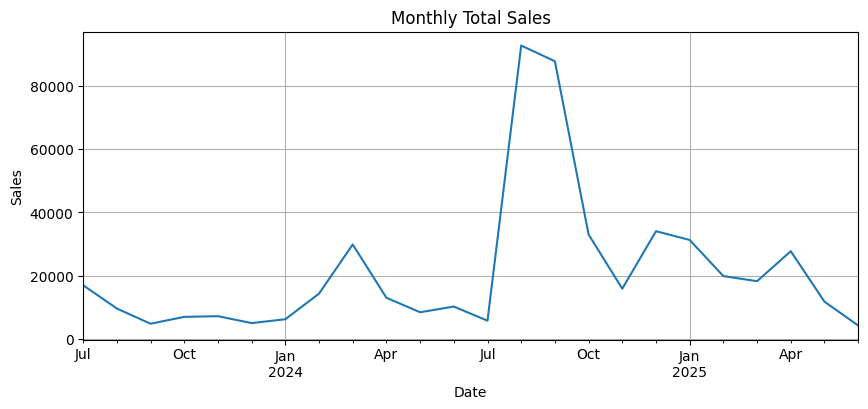

In [21]:
#Visualizing Monthly Sales Trend  
#Time Series Plot of Total Sales Over Time
monthly_sales.plot(figsize=(10,4))
plt.title("Monthly Total Sales")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [22]:
#ARIMA Model Training  
#Auto ARIMA Configuration and Summary for Forecasting
arima_model = auto_arima(monthly_sales, seasonal = False, trace = True)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=552.662, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=566.900, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=551.152, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=554.625, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=552.692, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=551.752, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=552.956, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=549.233, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=553.592, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=548.574, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=549.506, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=550.212, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=547.940, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=546.075, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=548.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -270.038
Date:                Thu, 03 Jul 2025   AIC                            546.075
Time:                        20:47:17   BIC                            549.610
Sample:                    07-01-2023   HQIC                           547.013
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.848e+04   7698.077      2.401      0.016    3396.691    3.36e+04
ma.L1          0.6749      0.293      2.304      0.021       0.101       1.249
sigma2       3.98e+08      1.006   3.96e+08      0.000    3.98e+08    3.98e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               161.45
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                             3.21
Prob(H) (two-sided):                  0.31   Kurtosis:                        13.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.91e+27. Standard errors may be unstable.
"""

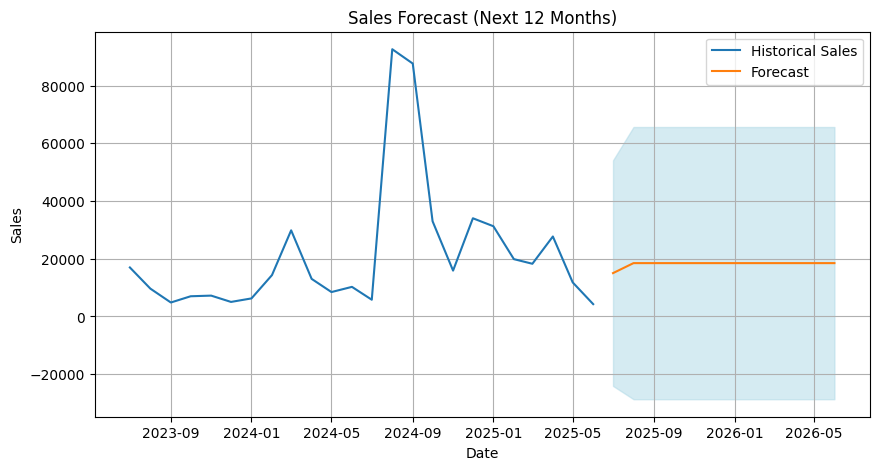

In [23]:
#Sales Forecast Visualization  
#Forecasting Next 12 Months Using ARIMA with Confidence Intervals
n_periods = 12  # Forecast 1 year
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Make a future date range
future_dates = pd.date_range(monthly_sales.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(future_dates, forecast, label='Forecast')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='lightblue', alpha=0.5)
plt.title("Sales Forecast (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
#Lowest Sales Record  
#Identifying the Order with Minimum Total Sales
main_data_encoded.loc[main_data_encoded['Total_Sales'].idxmin()]

Order_Date                         2025-04-03 00:00:00
Order_Day                                            3
Order_Month                                          4
Order_Year                                        2025
Order_Week_Day                                       3
Order_Week                                          14
Order_Quarter                                        2
Price                                               15
Quantity                                             1
Profit                                             4.5
Total_Sales                                         15
Customer_Name                            Emily Johnson
Product_Headphones                               False
Product_Jeans                                    False
Product_Laptop                                   False
Product_Refrigerator                             False
Product_Running Shoes                            False
Product_Smartphone                               False
Product_Sm

In [25]:
#Highest Sales Record  
#Identifying the Order with Maximum Total Sales
main_data_encoded.loc[main_data_encoded['Total_Sales'].idxmax()]

Order_Date                         2024-03-16 00:00:00
Order_Day                                           16
Order_Month                                          3
Order_Year                                        2024
Order_Week_Day                                       5
Order_Week                                          11
Order_Quarter                                        1
Price                                             1200
Quantity                                             5
Profit                                          1200.0
Total_Sales                                       6000
Customer_Name                                David Lee
Product_Headphones                               False
Product_Jeans                                    False
Product_Laptop                                   False
Product_Refrigerator                              True
Product_Running Shoes                            False
Product_Smartphone                               False
Product_Sm

In [26]:
#Summer 2024 Product Performance  
#Top-Selling Products During June–August 2024
main_data[
    (main_data['Order_Month'].isin([6, 7, 8])) & 
    (main_data['Order_Year'] == 2024)
].groupby('Product')['Total_Sales'].sum().sort_values(ascending=False)

Product
Laptop             34400
Refrigerator       21600
Washing Machine    19800
Smartphone         18500
Smartwatch          5700
Headphones          4600
Running Shoes       1800
Jeans               1080
T-Shirt              620
Book                 570
Name: Total_Sales, dtype: int64

In [27]:
#Summer 2024 Inventory Demand  
#Total Quantity Sold per Product (June–August 2024)
main_data[
    (main_data['Order_Month'].isin([6, 7, 8])) & 
    (main_data['Order_Year'] == 2024)
].groupby('Product')['Quantity'].sum().sort_values(ascending=False)

Product
Headphones         46
Laptop             43
Book               38
Smartwatch         38
Smartphone         37
Washing Machine    33
T-Shirt            31
Running Shoes      30
Jeans              27
Refrigerator       18
Name: Quantity, dtype: int64

In [28]:
#Summer 2024 Profitability  
#Total Profit per Product (June–August 2024)
main_data[
    (main_data['Order_Month'].isin([6, 7, 8])) & 
    (main_data['Order_Year'] == 2024)
].groupby('Product')['Profit'].sum().sort_values(ascending=False)

Product
Laptop             8600.0
Smartphone         4625.0
Refrigerator       4320.0
Washing Machine    3960.0
Smartwatch         1425.0
Headphones         1150.0
Running Shoes       720.0
Jeans               378.0
T-Shirt             217.0
Book                171.0
Name: Profit, dtype: float64